# What Makes the Most Popular Country for Studying Abroad?

#### By: Richard Mu and Xinyao Chen
### Introduction
Studying abroad has appeared to be increasing in popularity in recent years both in the Univeristy of Maryland and in other Universities across the United States. University of Maryland alone offers semester exchange program to over 60 countries around the world.

While we are excited to see that students has became more enthusiastic and understanding on the purpose and benefits of studying abroad, we also wanted to examine various attributes of the countries to see which ones may be the most suitable for studying abroad. We understand that selecting a country to study abroad in is a decision that each students make base on various factors, such as personal sentient and ethnic background. However, we are also curious about how the characteristics of each country, such as crime rates, may relate to the number of students studying abroad there.
### 1. DATA COLLECTION
There are several Python libraries that will be helpful in the process of our analysis. We will explain their functionality throughout this tutorial as they appear. Here are some documentation pages that we found convenient for referencing:<br>
1. [pandas library](https://pandas.pydata.org/pandas-docs/stable/)
2. [NumPy Manual](https://docs.scipy.org/doc/numpy/index.html)
3. [matplotlib pyplot library](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html)
4. [BeautifulSoup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
5. [Seaborn Visualization](https://seaborn.pydata.org/index.html)


In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import warnings
import requests
import re
from bs4 import BeautifulSoup
import seaborn as sns
import folium
pd.set_option('display.max_rows', 600)   # Set full visualization of dataframes 
warnings.filterwarnings('ignore')

After several attemps, we realized that there is not a collective source that contains all the information we would like to analyze, so we decided process data from multiple sources and combine them to create the most all-round dataset.
<br>
First, we found a [dataset](https://www.iie.org/Research-and-Insights/Open-Doors/Data/US-Study-Abroad/Destinations) that listed the number of students in the United States that studied abroad at each country in the 2017-2018 school year. The data was downloaded as an excel sheet (or .xlsx) format so we simply used a Pandas function to read it into a Pandas DataFrame.

In [2]:
travel_data_2017 = pd.read_excel(open('D3A1FE70.xlsx', 'rb'),
                           sheet_name = "data")
travel_data_2017.head(10)

,Destination,2017/18
0,Cameroon,57
1,Central African Republic,0
2,Chad,2
3,"Congo, Dem. Rep. of (Kinshasa)",6
4,"Congo, Rep. of (Brazzaville)",5
5,Equatorial Guinea,7
6,Gabon,4
7,São Tomé and Príncipe,0
8,Burundi,0
9,Djibouti,0


In addition, we decided to choose three attributes that each will represent a different perspective of each country to help us give characterization.
<br><br>
__First Attribute: Peacefulness__
<br>
As students studying in a foreign country, we may often find ourselves worreid of places with high crime rates or recent violent uprisings. We found a [Global Peace Index](https://www.kaggle.com/xenohunter/global-peace-index) dataset on kaggle that measures the peacefulness of a country from 2008 - 2019. As students studying abroad for the 2017-2018 semester should have mostly decided their destination in 2017, we only extraded data relating to the year 2017.
<br>
$*$*note: lower peace score reflects a higher peacefulness rating*$*$

In [3]:
peace_index = pd.read_csv('gpi-2008-2019.csv')
peace_index = peace_index[['Country','2017 rank', '2017 score']]
peace_index.head(10)

,Country,2017 rank,2017 score
0,Iceland,1,1.084
1,New Zealand,2,1.216
2,Portugal,3,1.273
3,Austria,4,1.292
4,Denmark,5,1.299
5,Canada,6,1.332
6,Singapore,12,1.400
7,Slovenia,9,1.373
8,Japan,10,1.377
9,Switzerland,7,1.368


__Second Attribute: Cost of Living__
<br>
Studying abroad can often be seen as expensive because of the initial traveling costs, application fees, and etc. Furthermore, the financial complications continues after students arrive in their host country and remains throughout their time abroad. We visited the webpage [Numbeo]('https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2017') for cost of living index data of each country in the year 2017. Since the page did not offer any exporting option, we used a get request and scraped the tabel from the resulting html.

In [4]:
r = requests.get('https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2017')
root = BeautifulSoup(r.content)

# Find table from html
table = root.find("table", {"id": "t2"})

# Convert to dataframe
cost_living = pd.read_html(str(table))
cost_living = cost_living[0]
cost_living = cost_living[['Country', 'Cost of Living Index']]
cost_living.head(10)

,Country,Cost of Living Index
0,Bermuda,146.19
1,Switzerland,122.06
2,Iceland,111.71
3,Norway,106.31
4,Bahamas,104.05
5,Us Virgin Islands,85.86
6,Japan,85.28
7,Italy,83.70
8,Denmark,83.02
9,Singapore,82.41


__Third Attribute: Happiness Score__
<br>
Finally, we collected found the happiness score of each country from the [World Happiness Report](https://worldhappiness.report/ed/2019/#read). These scores are reflected from "how happy the citizens perceive themselves to be". While there are many aspects of the local citizen's lives that are distinct from the lives of foreign students, we think that the happiness scores displays, to some degree, the living conditions of each country. Since it is exported as a CSV file, we used the read_csv function from the Pandas library.

In [5]:
happiness_df = pd.read_csv('2017-happiness.csv')
happiness_df = happiness_df[['Country','Happiness.Score']]
happiness_df = happiness_df.rename(columns={'Happiness.Score':'Happiness Score'})
happiness_df.head(10)

,Country,Happiness Score
0,Norway,7.537
1,Denmark,7.522
2,Iceland,7.504
3,Switzerland,7.494
4,Finland,7.469
5,Netherlands,7.377
6,Canada,7.316
7,New Zealand,7.314
8,Sweden,7.284
9,Australia,7.284


__Extra Information__
<br>
We also imported the geographic coordinate of each country for convenience of creating a map-based visualization later. Having a dataframe with the Longitude and Latitude information can be very helpful when using the folium library.

In [6]:
centroids = pd.read_csv('country_centroids_az8.csv')
centroids = centroids[['sovereignt','Longitude','Latitude']]
centroids.head(5)

,sovereignt,Longitude,Latitude
0,Netherlands,-69.982677,12.520880
1,Afghanistan,66.004734,33.835231
2,Angola,17.537368,-12.293361
3,United Kingdom,-63.064989,18.223959
4,Albania,20.049834,41.142450


### 2. PROCESSING AND TIDYING
After reading in datasets from various sources, we now have 5 different DataFrames storing data we will be using. Since our goal is to visualize and process attributes of each country, creating one complete table with all the information combined would be much more convenient. We decided to merge the different tables together with the country's name. Unfortunately, because these datasets all originated from different sources, not every country will be represented in every dataset. We performed an "inner-join" on each step of the merging process and dropped the rows with a country name that was missing from any dataset.

We also decided to primarily use the "scores" instead of "rankings" for each attribute. We found that rankings are only meaningful when compared to with other entries in the same dataset, but the scores, or indexes, are more relevant when used for analysis of multiple attributes.

Note that the "Country Name" column of each DataFrame may be named differently. Choosing to display a section of each DataFrame using the *head()* function can be useful in helping us see the names of columns and the corresponding data. After creating a DataFrame by combining the columns of previously collected data, we also sorted the DataFrame from least popular countries to most popular countries. 

In [7]:
fulldata = pd.merge(left = travel_data_2017,right = peace_index, left_on="Destination", right_on="Country")
fulldata = fulldata[['Destination','2017/18', '2017 score']]
fulldata.columns = ['Country','Student Count','Peace Score']
fulldata = pd.merge(left = fulldata, right = happiness_df, left_on="Country", right_on="Country")
fulldata = pd.merge(left = fulldata, right = cost_living, left_on="Country", right_on="Country")
fulldata = fulldata.sort_values('Student Count').reset_index(drop=True)
print(fulldata.shape)

Outliers_removed= fulldata.iloc[:100]

fulldata.head(10)


(103, 5)


,Country,Student Count,Peace Score,Happiness Score,Cost of Living Index
0,Libya,0,3.340,5.525,45.85
1,Belarus,0,2.106,5.569,33.84
2,Syria,0,3.462,3.462,28.31
3,Kuwait,0,1.823,6.105,75.24
4,Algeria,1,2.188,5.872,32.38
5,Iran,2,2.344,4.692,38.26
6,Iraq,3,3.516,4.497,47.04
7,Pakistan,5,3.080,5.269,27.18
8,Moldova,6,1.944,5.838,28.37
9,Saudi Arabia,8,2.346,6.344,48.37


### 3. EXPLORATORY ANALYSIS AND VISUALIZATION
In this section, we work towards creating meaningful visualizations that will either help us better examine the information we have or inspect how they relate to each other.
<br><br>
#### Top 50 Distribution through Bar Graph
First, we are interested in finding out the distribution of United States students in each country. After some experimenting, we realized that both verticle and horizontal bar graphs appear overcrowded when attempting to input over 100 entries. Since the DataFrame was sorted with student counts in ascending order, we decided to graph the last 50 rows of the DataFrame in order to see how the most popular country compares to others.

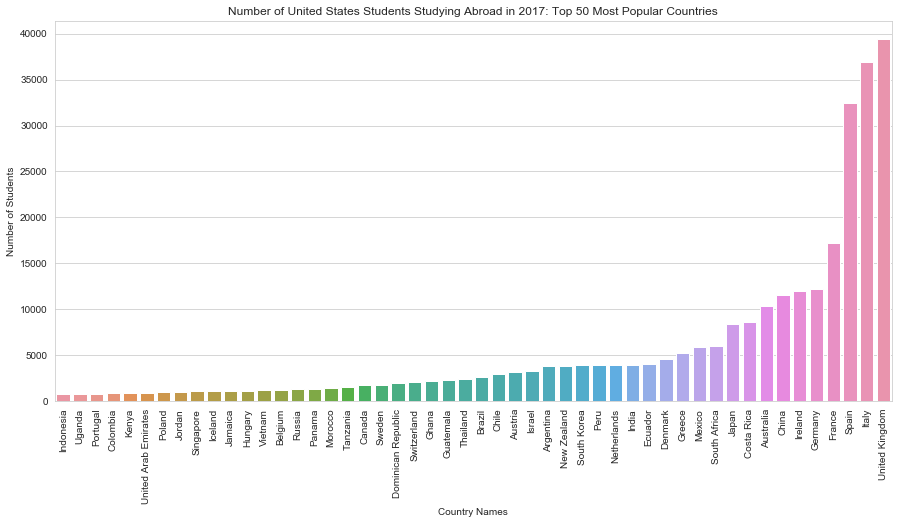

In [8]:
mostPopular50 = fulldata.iloc[-50:] #selecting the bottom 50 rows
matplotlib.rcParams['figure.figsize']=[15, 7] #changing size of plot
sns.set_style("whitegrid")
plt.xticks(rotation='vertical') #rotating labels
bar_count = sns.barplot( x = "Country", y = "Student Count",data = mostPopular50, orient='v')
plt.xlabel('Country Names')
plt.ylabel('Number of Students')
plt.title('Number of United States Students Studying Abroad in 2017: Top 50 Most Popular Countries')
plt.show()

We can see that there exists a large gap between countrie's popularity distribution. Even after we isolated the top 50 most popular country, the distinction between the number of United Students who studies abroad in the top 3 countries and other countries in the top 50 is very visible. The fourth most popular country - France, had about 17,000 students, while the third most popular country - Spain had over 30,00 students.

#### Outliers
For the purpose of better picturing the disparity between popularity of countries, we also used all student counts from 103 different countries to create a box-and-whiskers-plot. As we can see in the plot below, the outlier-excluded-maximum of student count is around 5,000 students, and the medium of student count appears to be less than 1,000. There are quite a few outliers representing countries that are much more popular among the students, and within these outliers we see 3 countries standing much further out compared to others - United Kingdom, Italy, and Spain (names found in bargraph above). We will pay special attention to these three countries and see how their attributes may differ from others.

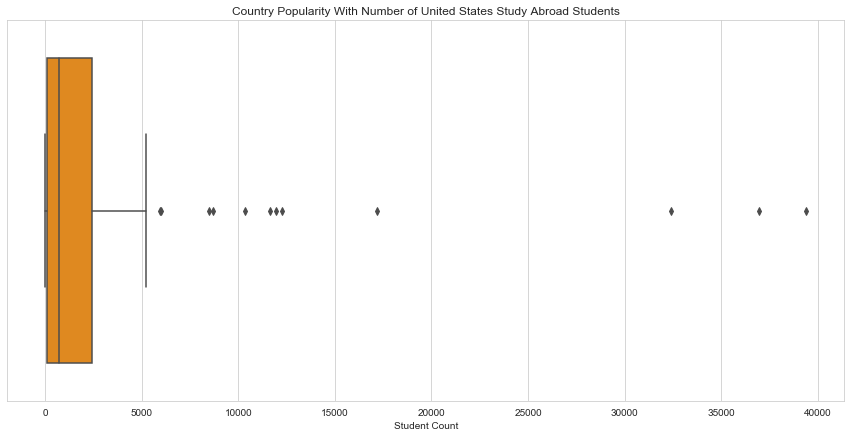

In [9]:
plt.clf()
plt.xlabel('Number of Students')
plt.title('Country Popularity With Number of United States Study Abroad Students')
sns.boxplot(x=fulldata['Student Count'], color = 'darkorange')
plt.show()

#### Student Count and Country Attribute Relationship.

To visualize the relationship between the different attributes of a country and the number of students that study abroad there, we impliment a scatter plot using matplotlibs and seaborns lmplot with the attributes as the x axis and the student count as the y axis. 
We label the three top outliers, United Kingdoms, Italy, and Spain, for each graph, to see just how different they are compared to the others, as well as notice any trends. We also plot a line to show where the United States stand, as that is where the students are all traveling from, to visualize comparitive trends. 
<br><br>
##### Student Count vs Peace Score

<Figure size 1080x504 with 0 Axes>

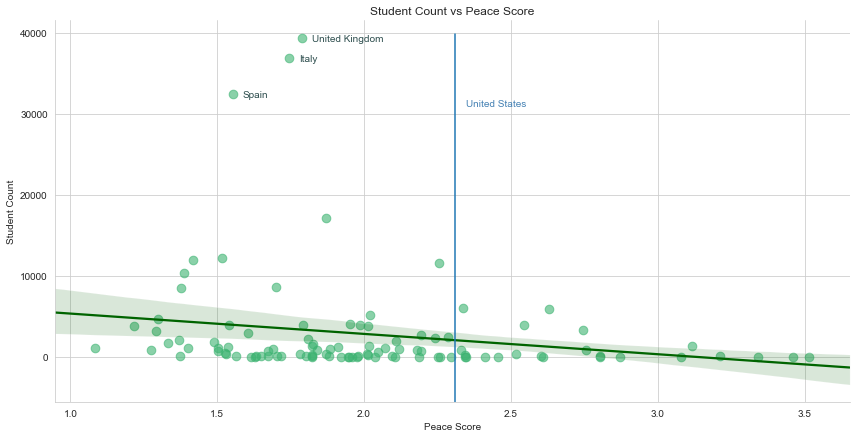

In [10]:
#fit, ax = plt.subplots(figsize = (12,10))
plt.clf()
peace = sns.lmplot(x='Peace Score', y ="Student Count", size=6, aspect =  2, 
                   scatter_kws={"s":75,"alpha":0.6,"color":'mediumseagreen'},
                   line_kws={"color":'darkgreen'},data = fulldata)

ax = peace.axes[0,0]
ax.set_title('Student Count vs Peace Score')

dataCoords = list(zip(fulldata['Peace Score'], fulldata['Student Count']))
for i in range(len(dataCoords)):
    point = dataCoords[i]
    if point[1] > 37000: #United Kingdom
        ax.text(point[0]+0.035, point[1]-400, 'United Kingdom', color = 'darkslategray')
    elif point[1] > 35000: #Italy
        ax.text(point[0]+0.035, point[1]-400, 'Italy', color = 'darkslategray')
    elif point[1] > 30000: #Spain
        ax.text(point[0]+0.035, point[1]-400, 'Spain', color = 'darkslategray')
        
#graphing line for United States
USPeace = peace_index.loc[peace_index['Country'] == 'United States']['2017 score']
plt.axvline(USPeace.values[0],0,0.965)
ax.text(USPeace.values[0] + 0.035, 31000, 'United States', color = 'steelblue')

plt.show()

<Figure size 1080x504 with 0 Axes>

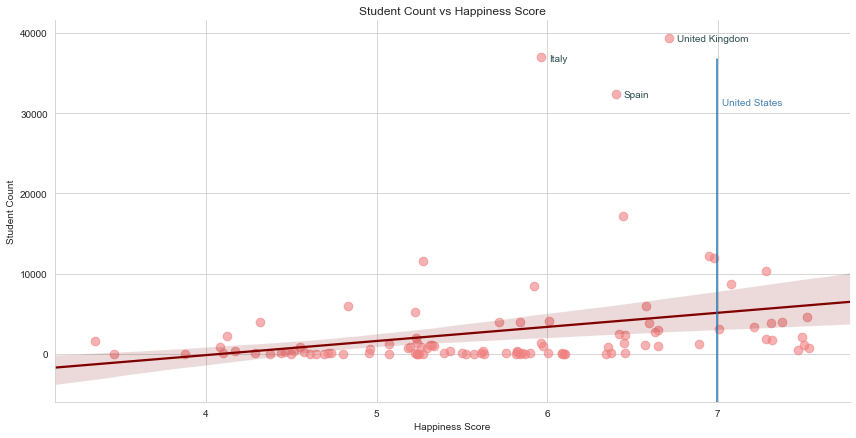

In [11]:
plt.clf()
happiness = sns.lmplot(x='Happiness Score', y ="Student Count", size=6, aspect = 2, 
                   scatter_kws={"s":75,"alpha":0.6,"color":'lightcoral'},
                   line_kws={"color":'maroon'},data = fulldata)

ax = happiness.axes[0,0]
ax.set_title('Student Count vs Happiness Score')

dataCoords = list(zip(fulldata['Happiness Score'], fulldata['Student Count']))
for i in range(len(dataCoords)):
    point = dataCoords[i]
    if point[1] > 37000: #United Kingdom
        ax.text(point[0]+0.045, point[1]-400, 'United Kingdom', color = 'darkslategray')
    elif point[1] > 35000: #Italy
        ax.text(point[0]+0.045, point[1]-400, 'Italy', color = 'darkslategray')
    elif point[1] > 30000: #Spain
        ax.text(point[0]+0.045, point[1]-400, 'Spain', color = 'darkslategray')

#graphing United States
USHappiness = happiness_df.loc[happiness_df['Country'] == 'United States']['Happiness Score']
plt.axvline(USHappiness.values[0],0,0.90)
ax.text(USHappiness.values[0] + 0.035, 31000, 'United States', color = 'steelblue')

plt.show()

From the scatter plot of student count and happiness, we can see the slight trend that countries with a higher happiness score tend to have more study abroad there. The United States does have a fairly high HAppiness score, so the majority of countries that students go to do have a lower score. The main outliers, while of lower happiness score than the United States, still score higher than average when compared to the rest of the countries. 
<br><br>

##### Student Count vs Cost of Living

<Figure size 1080x504 with 0 Axes>

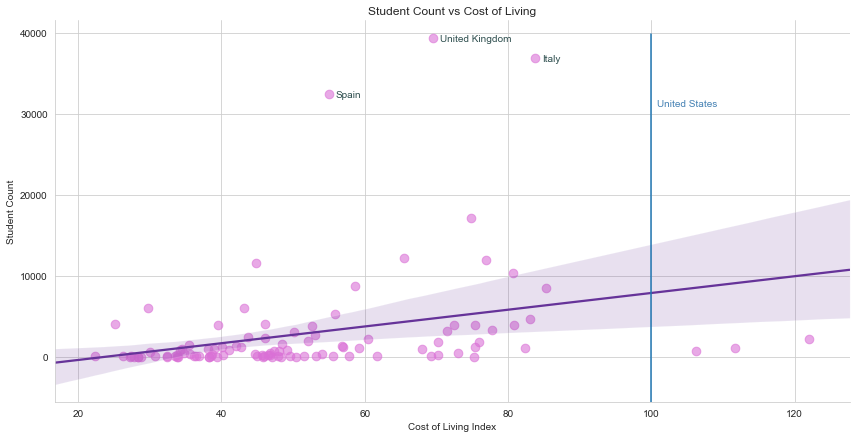

In [12]:
plt.clf()
cost = sns.lmplot(x='Cost of Living Index', y ="Student Count", size=6, aspect = 2, 
                   scatter_kws={"s":75,"alpha":0.6,"color":'orchid'},
                   line_kws={"color":'rebeccapurple'},data = fulldata)

ax = cost.axes[0,0]
ax.set_title('Student Count vs Cost of Living')

dataCoords = list(zip(fulldata['Cost of Living Index'], fulldata['Student Count']))
for i in range(len(dataCoords)):
    point = dataCoords[i]
    if point[1] > 37000: #United Kingdom
        ax.text(point[0]+1, point[1]-400, 'United Kingdom', color = 'darkslategray')
    elif point[1] > 35000: #Italy
        ax.text(point[0]+1, point[1]-400, 'Italy', color = 'darkslategray')
    elif point[1] > 30000: #Spain
        ax.text(point[0]+1, point[1]-400, 'Spain', color = 'darkslategray')

USCost = 100
plt.axvline(USCost,0,0.965)
ax.text(USCost + 0.8, 31000, 'United States', color = 'steelblue')

plt.show()

The scatter plot of student count and cost of living also shows that the amount of students that study at the country increases with a countries cost of living. However, nearly all countries have a lower cost of living than New York, which is what the cost of living index is based around. As there was no cost of living data for the United States with the dataset found, we will use this as the placeholder for the United States. The outliers do generally have a higher cost of living, but still fall below the United States. 
<br><br>
##### Plotting all attributes in relationship to each other
To better visualize how all the country attributes relate to each other instead of just how they affect the amount of students that study abroad at said country, we created a scatter plot with the peace score as the x-axis, the cost of living as the y-axis, and the happiness score as the size and color of the point. The grater the happiness score, the larger and darker the point is.

In [13]:
category = []
catkey = ['2 to 3','3 to 4','4 to 5','5 to 6','6 to 7','7 to 8']
for index, row in fulldata.iterrows():
    if row[3] >= 2 and row[3] < 3:
        category.append('2 to 3')
    if row[3] >= 3 and row[3] < 4:
        category.append('3 to 4')
    if row[3] >= 4 and row[3] < 5:
        category.append('4 to 5')
    if row[3] >= 5 and row[3] < 6:
        category.append('5 to 6')
    if row[3] >= 6 and row[3] < 7:
        category.append('6 to 7')
    if row[3] >= 7 and row[3] < 8:
        category.append('7 to 8')

fulldata['Happiness Category'] = category

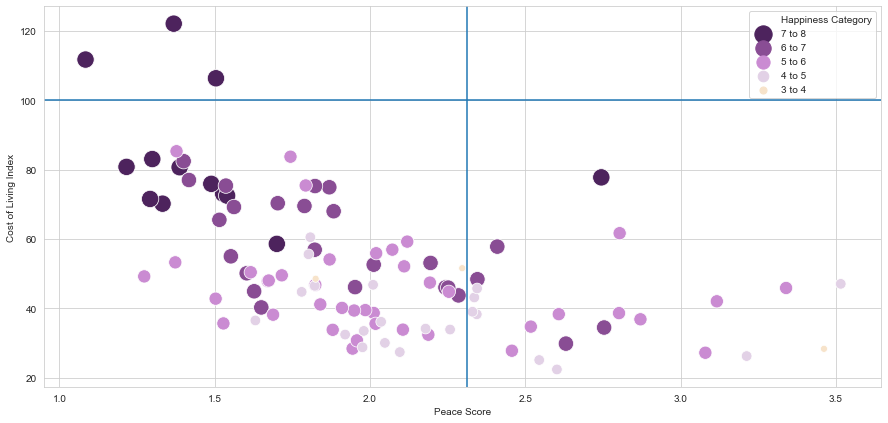

In [14]:
#cmap = sns.cubehelix_palette(dark = .3, light = .8, as_cmap=True)
plt.clf()
palette = {"2 to 3":"#FFF8EF","3 to 4":"#F7E3CA", "4 to 5":"#E2D1E6", "5 to 6":"#ca8bd2",
           "6 to 7":"#894d94", "7 to 8":"#4D235D"}

sizesdict = {"2 to 3":2,"3 to 4":4, "4 to 5":6, "5 to 6":8,
           "6 to 7":10, "7 to 8":12}

hap_sort = fulldata.sort_values("Happiness Score", ascending = False)
hap_peace = sns.scatterplot(x="Peace Score", y="Cost of Living Index", hue="Happiness Category",
                            size = "Happiness Category",
                            sizes = (50,300),
                            palette=palette,
                            data = hap_sort)

USCost = 100
plt.axhline(USCost,0,1)
ax.text(1.0, USCost+0.8, 'United States', color = 'steelblue')

USPeace = peace_index.loc[peace_index['Country'] == 'United States']['2017 score']
plt.axvline(USPeace.values[0],0,1)
ax.text(USPeace.values[0] + 0.035, 90, 'United States', color = 'steelblue')

hap_peace


At a glance, we can see that the traits follow the same trends as their individual plots with student count. A lower peace score, or a more peaceful country, tends to have a higher cost of living as well. We also see how a large conentration of darker and larger points gather at higher cost of living and lower peace score, showing that all these three traits do seem to have some sort of relationship with each other.
<br><br>
### World Map
To visualize on a map how many students decided to study at each country, we created a choropleth map that shaded countries darker if more students decided to study abraod there. Due to the large range, to have a noncluttered index, we used multiple layers. By keeping the outliers distinct from the rest, we can have smaller ranges between each cutoff to have a more distinct visualization to compare the countries. 

In [15]:
country_geo = 'world-countries.json'
palette = sns.cubehelix_palette(8, start=0.5, rot=-.75)

travel_data_2017 = travel_data_2017.sort_values('2017/18').reset_index(drop=True)
tdata_1 = travel_data_2017.iloc[-3:]
tdata_2 = travel_data_2017.iloc[:216]

map = folium.Map(location=[35, 0], zoom_start=1.7)
map.choropleth(geo_data=country_geo, data=tdata_2,
              columns=['Destination', '2017/18'],
              key_on='feature.properties.name',
              fill_color='Oranges', nan_fill_color = 'cornsilk',
              fill_opacity=0.7,
              line_opacity=0.2,
              legend_name='Number of U.S. Students',
               threshold_scale=[0,1000,3000,7500,12500,17500])
map.choropleth(geo_data=country_geo, data=tdata_1,
              columns=['Destination', '2017/18'],
              key_on='feature.properties.name',
              fill_color='Purples', nan_fill_color = 'cornsilk',
              fill_opacity=0.7, nan_fill_opacity=0.0,
              line_opacity=0.2,
              legend_name=' ',
                threshold_scale=[30000,30000,30000,30000,30000,40000])
map

We can see from this map that the countries with the largest number of students that study abroad there are heavily concentrated in Europe. All three major outliers are also found there. The area that sees the least amount of students seem to be in the areas of Africa and the Middle East.

## Further Analysis and Machine Learning

For this phase in the Data Science Lifeceycle, we will be conducting a polynomial regression analysis on the data in order to predict the number of students that would study abroad at a country based off the countrie's happiness score, peace score, and cost of living.

### Why Polynomial
When taking a closer look at the plots produced during visualization, it is clear that each attribute is not perfectly linear. Taking into account the outlier positions, as well as the positions of other countries with higher student count, a polynomial fit may be better to consider as the data shows that it isn't as simple as a one to one relationship throughout.
#### Polynomial Line of Best Fit
We graph the same plots using each attribute vs student count, but we use the parameter of order = 3 to visualize an estimated polynomial regression instead.

<Figure size 1080x504 with 0 Axes>

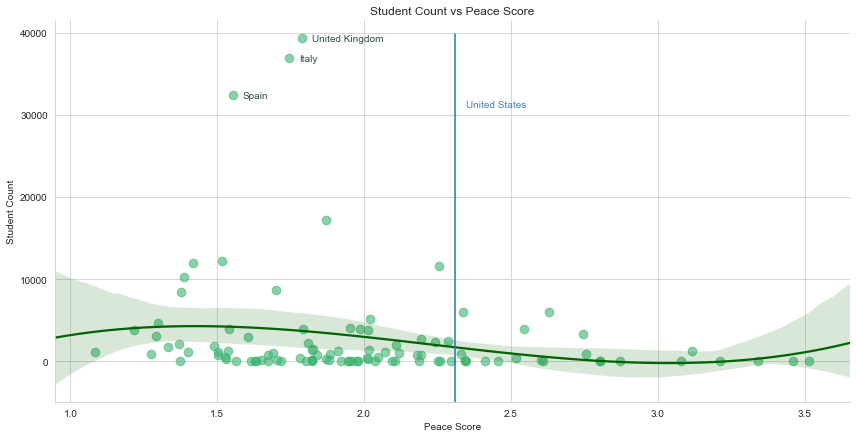

In [16]:
plt.clf()
peace = sns.lmplot(x='Peace Score', y ="Student Count", size=6, aspect =  2, 
                   scatter_kws={"s":75,"alpha":0.6,"color":'mediumseagreen'},
                   line_kws={"color":'darkgreen'},order = 3, data = fulldata)

ax = peace.axes[0,0]
ax.set_title('Student Count vs Peace Score')

dataCoords = list(zip(fulldata['Peace Score'], fulldata['Student Count']))
for i in range(len(dataCoords)):
    point = dataCoords[i]
    if point[1] > 37000: #United Kingdom
        ax.text(point[0]+0.035, point[1]-400, 'United Kingdom', color = 'darkslategray')
    elif point[1] > 35000: #Italy
        ax.text(point[0]+0.035, point[1]-400, 'Italy', color = 'darkslategray')
    elif point[1] > 30000: #Spain
        ax.text(point[0]+0.035, point[1]-400, 'Spain', color = 'darkslategray')
        
#graphing line for United States
USPeace = peace_index.loc[peace_index['Country'] == 'United States']['2017 score']
plt.axvline(USPeace.values[0],0,0.965)
ax.text(USPeace.values[0] + 0.035, 31000, 'United States', color = 'steelblue')

plt.show()

<Figure size 1080x504 with 0 Axes>

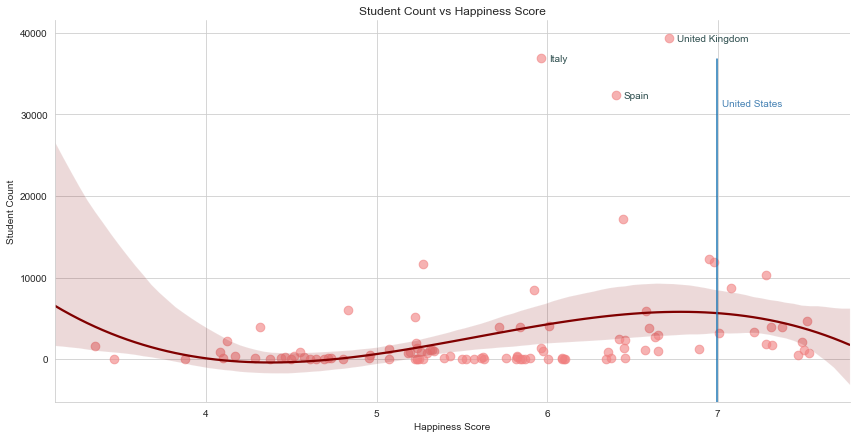

In [17]:
plt.clf()
happiness = sns.lmplot(x='Happiness Score', y ="Student Count", size=6, aspect = 2, 
                   scatter_kws={"s":75,"alpha":0.6,"color":'lightcoral'},
                   line_kws={"color":'maroon'},order = 3,data = fulldata)

ax = happiness.axes[0,0]
ax.set_title('Student Count vs Happiness Score')

dataCoords = list(zip(fulldata['Happiness Score'], fulldata['Student Count']))
for i in range(len(dataCoords)):
    point = dataCoords[i]
    if point[1] > 37000: #United Kingdom
        ax.text(point[0]+0.045, point[1]-400, 'United Kingdom', color = 'darkslategray')
    elif point[1] > 35000: #Italy
        ax.text(point[0]+0.045, point[1]-400, 'Italy', color = 'darkslategray')
    elif point[1] > 30000: #Spain
        ax.text(point[0]+0.045, point[1]-400, 'Spain', color = 'darkslategray')

#graphing United States
USHappiness = happiness_df.loc[happiness_df['Country'] == 'United States']['Happiness Score']
plt.axvline(USHappiness.values[0],0,0.90)
ax.text(USHappiness.values[0] + 0.035, 31000, 'United States', color = 'steelblue')

plt.show()

<Figure size 1080x504 with 0 Axes>

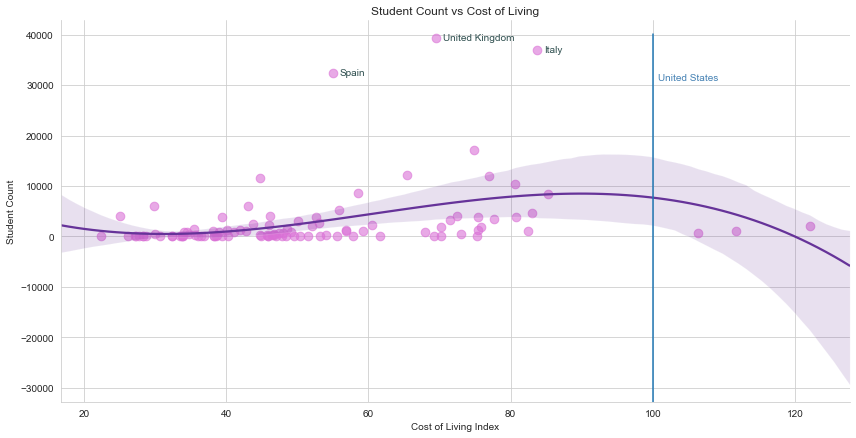

In [18]:
plt.clf()
cost = sns.lmplot(x='Cost of Living Index', y ="Student Count", size=6, aspect = 2, 
                   scatter_kws={"s":75,"alpha":0.6,"color":'orchid'},
                   line_kws={"color":'rebeccapurple'},order = 3,data = fulldata)

ax = cost.axes[0,0]
ax.set_title('Student Count vs Cost of Living')

dataCoords = list(zip(fulldata['Cost of Living Index'], fulldata['Student Count']))
for i in range(len(dataCoords)):
    point = dataCoords[i]
    if point[1] > 37000: #United Kingdom
        ax.text(point[0]+1, point[1]-400, 'United Kingdom', color = 'darkslategray')
    elif point[1] > 35000: #Italy
        ax.text(point[0]+1, point[1]-400, 'Italy', color = 'darkslategray')
    elif point[1] > 30000: #Spain
        ax.text(point[0]+1, point[1]-400, 'Spain', color = 'darkslategray')

USCost = 100
plt.axvline(USCost,0,0.965)
ax.text(USCost + 0.8, 31000, 'United States', color = 'steelblue')

plt.show()

These estimates seem to be much better at taking into account that the countries with the highest student count aren't necessarily the highest or lowest of whatever attribute is being estimated.

To further confirm that Linear Regression may not be the best choice, we will be creating a linear model using statsmodels and finding the R^2 value, which shows the accuracy of the linear fit.


R^2 Value: 0.09998800760827131


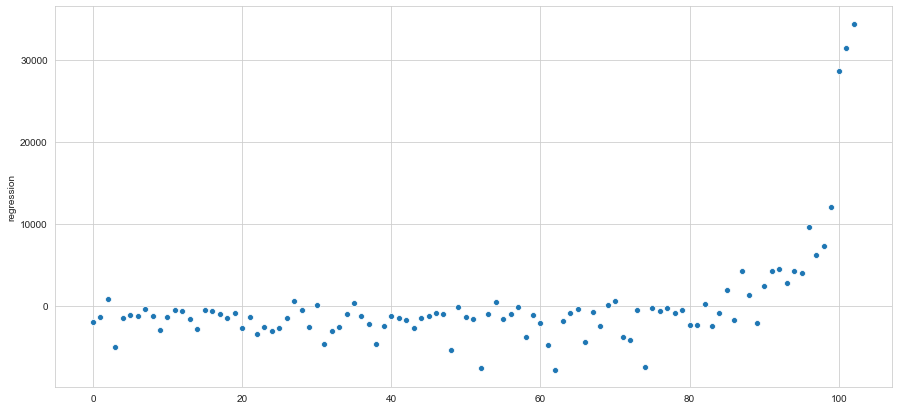

In [23]:
from sklearn import linear_model
features = fulldata[['Peace Score','Happiness Score', 'Cost of Living Index']]
results = fulldata[['Student Count']]

X = features
y = results['Student Count']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
axis = list(range(0,103))

predicted = model.predict(X)
fdc = fulldata.copy()  
counter = 0
for index, row in fulldata.iterrows():
    regression = row[1] - predicted[counter]
    fdc.at[index, 'regression'] = regression
    counter = counter +1
fdc
residualplot = sns.scatterplot(x=axis, y="regression",
                            data = fdc)

print("R^2 Value: "+ str(lm.score(X,y)))


From the graph of residuals between predicted and actual values, we can see that the model has differences in the thousands. For the coountries with higher student counts, they are vastly underestimated by the linear model, which makes sense given the vast difference between countries of lower and higher student count. The lower countries, while not to an as harsh degree, are generally overestimated as well.
We can also see that the R^2 is terrible, at a value of around .099988. From these two factors, a better model than a linear function should be used.

R^2 Value: 0.25978996791362485


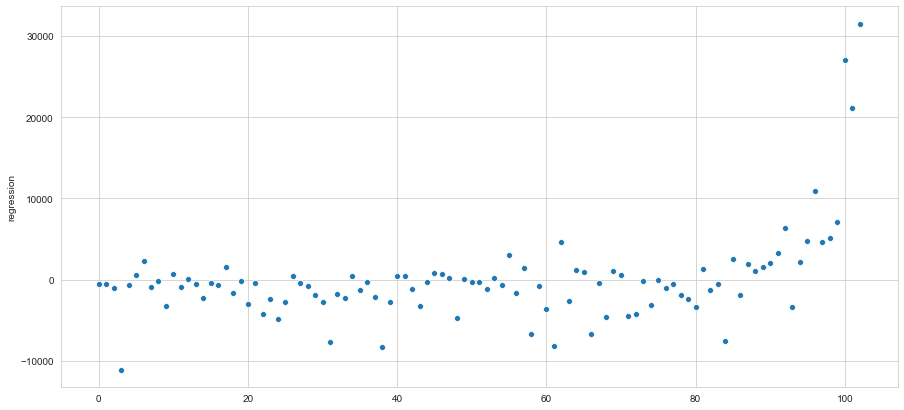

In [24]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(X)
model = lm.fit(x_poly, y)

predicted = model.predict(x_poly)
counter = 0
for index, row in fulldata.iterrows():
    regression = row[1] - predicted[counter]
    fdc.at[index, 'regression'] = regression
    counter = counter +1

fdc
residualplot = sns.scatterplot(x=axis, y="regression",
                            data = fdc)


print("R^2 Value: "+ str(lm.score(x_poly,y)))


While the R^2 has increased, it is still quite bad. This is likely heavily related to the outliers, which differ by far too large of a proportion. The graph of residuals hold the same pattern, and doesn't change much as far the higher countries are considered, though the lower countries due have a slightly more accurate prediction, albeit still quite unreliable. 
One thing to try is to remake the model with the 3 main outliers removed. 

0.2673316082430528

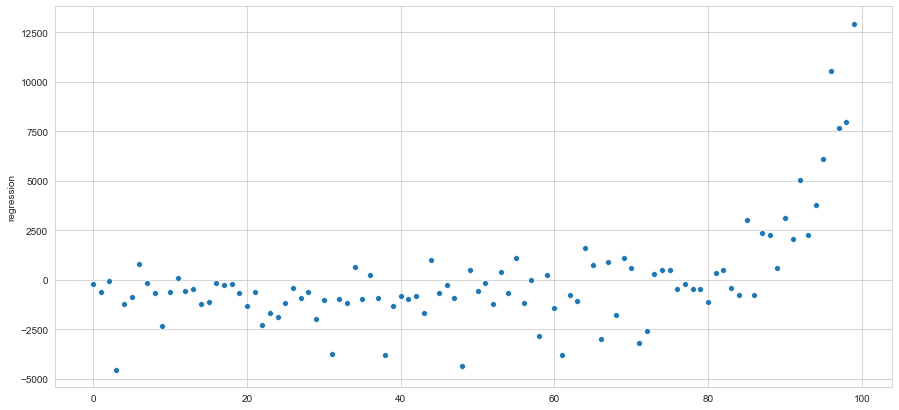

In [21]:
features = Outliers_removed[['Peace Score','Happiness Score', 'Cost of Living Index']]
results = Outliers_removed[['Student Count']]

X = features
y = results['Student Count']

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(X)
model = lm.fit(x_poly, y)
axis = list(range(0,100))

predicted = model.predict(x_poly)
counter = 0
for index, row in Outliers_removed.iterrows():
    regression = row[1] - predicted[counter]
    Outliers_removed.at[index, 'regression'] = regression
    counter = counter + 1
fdc
residualplot = sns.scatterplot(x=axis, y="regression",
                            data = Outliers_removed)
lm.score(x_poly, y)

However, even with the majors outliers removed, the R^2 value is still incredibly low. The residual plot follow the same exponential pattern, though much less harsh as the three major countries with differences in the 30000s are no longer considered. We can see that the predictions for the lower countries are still becoming slightly more accurate. 
A number of factors could be impacting this, such as the low amount of data that we have to work with. Furthermore, we at the moment have only three features, and despite the relationship they have with student count, it is possible that it is not enough to explain the very large differences of the number of students studying abroad at these countries. 